<h1 align="center">Boston Housing Price Prediction - part 3 </h1>
<h2 align="center">Support Vector Machines for Regression</h2>
<h3 align="center">Rositsa Chankova</h3>

### Intro 
**Support Vector Regression gives the flexibility to define how much <span style="color:red">error</span> is acceptable in the model and will find an appropriate line (or hyperplane in higher dimensions) to fit the data.**

**In most linear regression models, the objective is to minimize the sum of squared errors, i.e. Ordinary Least Squares (OLS).**

**In contrast to OLS, the objective function of SVR is to minimize the <span style="color:red">coefficients</span>  — more specifically, the L2-norm of the coefficient vector — not the squared error. The error term is instead handled in the constraints, where the absolute error less than or equal to a specified margin, called the maximum error, $\epsilon$  (epsilon) is set. The epsilon then can be tuned to gain the desired accuracy of the model.**

In [15]:
from sklearn.datasets import load_boston 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import boston_valuation as val
%matplotlib inline

boston_dataset = load_boston()

### Create a pandas dataframe and add column with the price (target)

In [16]:
data = pd.DataFrame(data=boston_dataset.data, columns=boston_dataset.feature_names)
data['PRICE'] = boston_dataset.target

In [17]:
len(data)

506

In [18]:
data.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [19]:
abs(data.corr())['PRICE'].sort_values(ascending=False)

PRICE      1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: PRICE, dtype: float64

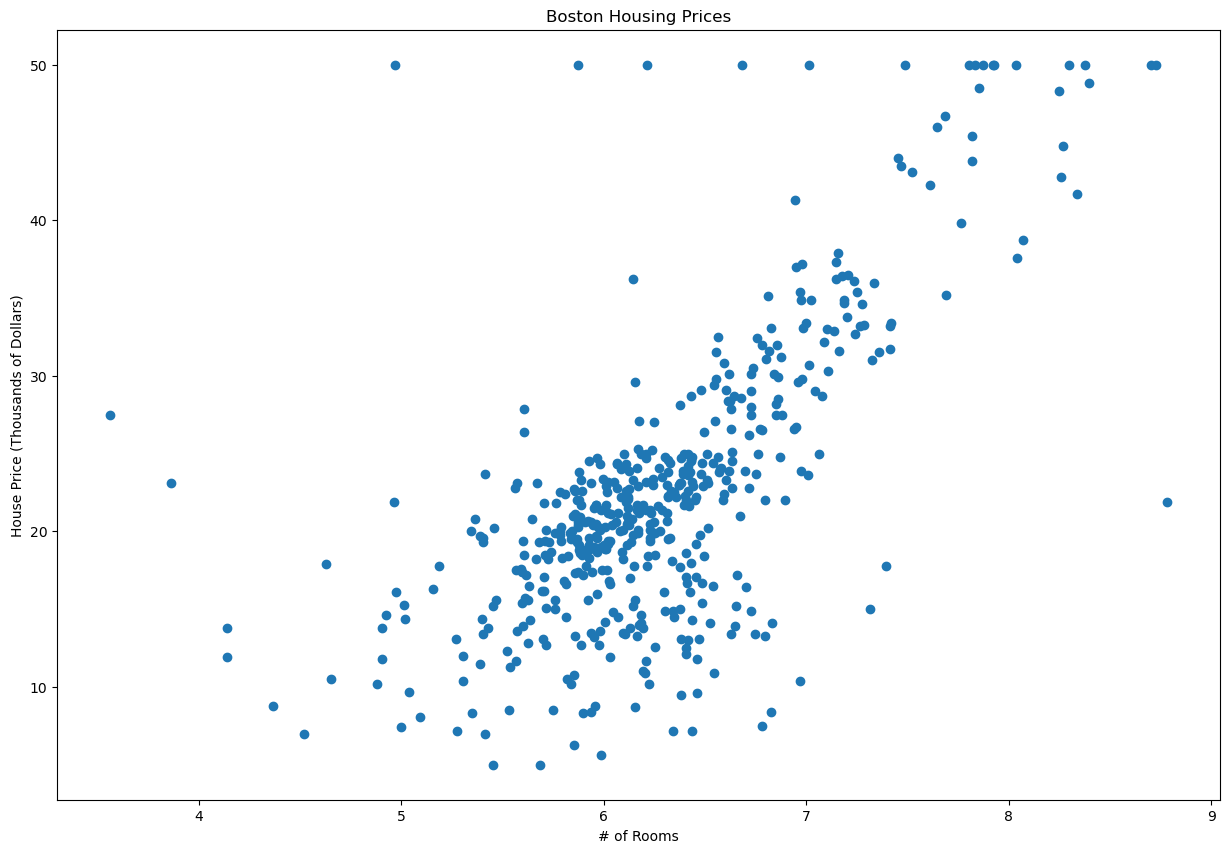

In [20]:
plt.figure(figsize=(15,10))
plt.scatter(x=data['RM'], y=data['PRICE'])
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('Boston Housing Prices')
plt.show()

## Linear Regression

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = np.array(data['RM']).reshape(-1,1)
y = np.array(data['PRICE']).reshape(-1,1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
lm = LinearRegression()

In [26]:
lm.fit(X_train, y_train)

LinearRegression()

Intercept: -35.424
Coefficient: 9.213
MAE = $4,521.71


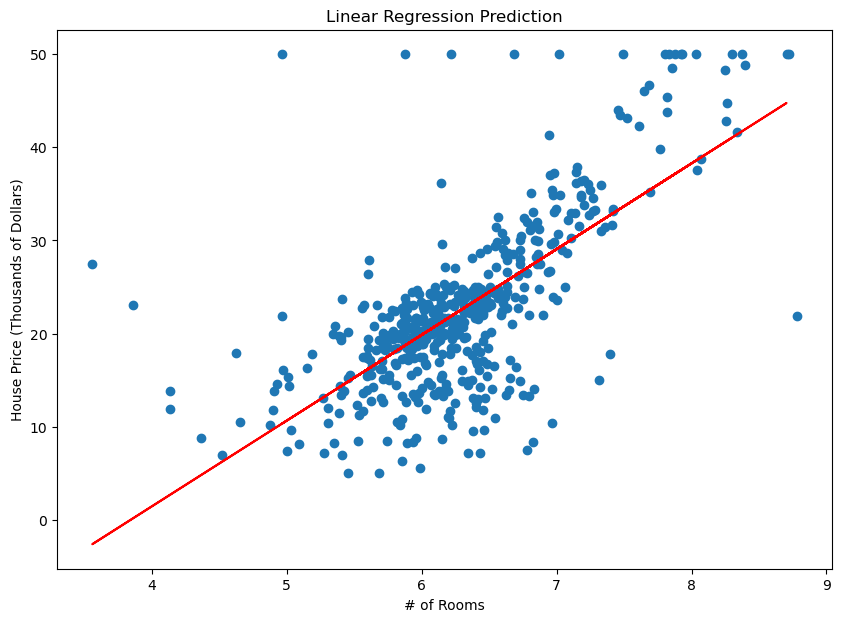

In [27]:
from sklearn.metrics import mean_absolute_error 

print("Intercept: {:,.3f}".format(lm.intercept_))
print("Coefficient: {:,.3f}".format(lm.coef_[0]))
    
mae = mean_absolute_error(y_test, lm.predict(X_test))
print("MAE = ${:,.2f}".format(1000*mae))

# Plot outputs
plt.figure(figsize=(10,7))
plt.scatter(x=data['RM'], y=data['PRICE'])
plt.plot(X_test, lm.predict(X_test), color='red')
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('Linear Regression Prediction')
plt.show()

**The plot above shows the results of a trained Linear Regression model on the Boston Housing Prices data.**

## Support Vector Regression

### Define performance results function

In [28]:
def svr_results(y_test, X_test, fitted_svr_model):
    
    print("C: {}".format(fitted_svr_model.C))
    print("Epsilon: {}".format(fitted_svr_model.epsilon))
    
    print("Intercept: {:,.3f}".format(fitted_svr_model.intercept_[0]))
    print("Coefficient: {:,.3f}".format(fitted_svr_model.coef_[0]))
    
    mae = mean_absolute_error(y_test, fitted_svr_model.predict(X_test))
    print("MAE = ${:,.2f}".format(1000*mae))
    
    perc_within_eps = 100*np.sum(y_test - fitted_svr_model.predict(X_test) < eps) / len(y_test)
    print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))
    
    # Plot outputs
    plt.figure(figsize=(10,7))
    plt.scatter(x=data['RM'], y=data['PRICE'])
    plt.plot(X_test, fitted_svr_model.predict(X_test), color='red')
    plt.plot(X_test, fitted_svr_model.predict(X_test)+eps, color='black')
    plt.plot(X_test, fitted_svr_model.predict(X_test)-eps, color='black')
    plt.xlabel('# of Rooms')
    plt.ylabel('House Price (Thousands of Dollars)')
    plt.title('SVR Prediction')
    plt.show()

## Simple Linear Support Vector Regression

In [29]:
from sklearn.svm import LinearSVR

In [30]:
eps = 5
svr = LinearSVR(epsilon=eps, C=0.01, fit_intercept=True)

In [31]:
svr.fit(X_train, y_train)

LinearSVR(C=0.01, epsilon=5)

C: 0.01
Epsilon: 5
Intercept: 0.369
Coefficient: 3.135
MAE = $5,892.98
Percentage within Epsilon = 73.53%


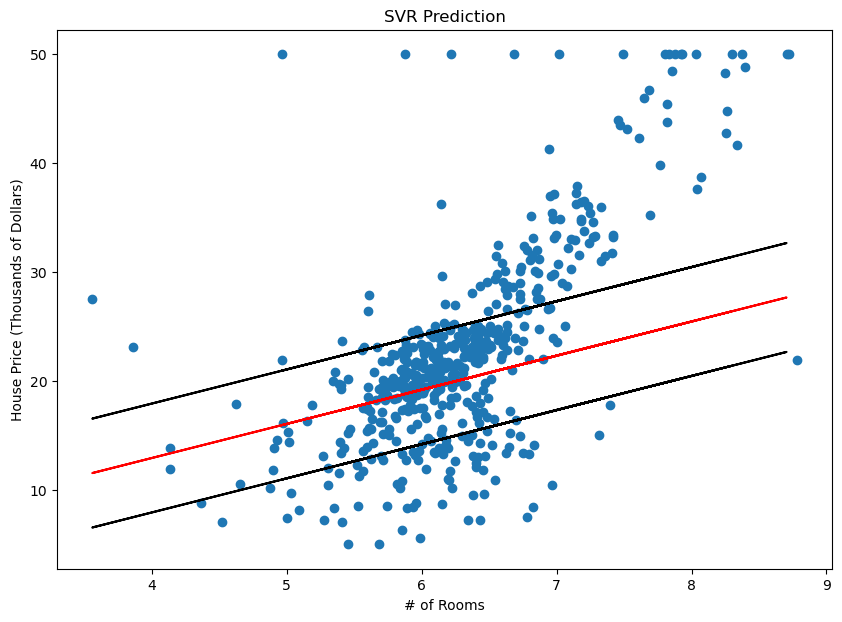

In [32]:
svr_results(y_test, X_test, svr)

**The plot above shows the results of a trained SVR model on the Boston Housing Prices data. The red line represents the line of best fit and the black lines represent the margin of error $\epsilon$, which we set to 5 (&#36;5,000).**

**This algorithm doesn’t work for all data points. It solved the objective function as best as possible but for some of the points still falls outside the margins. As such, one need to account for the possibility of errors that are larger than  $\epsilon$.**

**This could be done with <span style="color:red">slack</span>  variables. The concept of slack variables is as follows: for any value that falls outside of $\epsilon$ , one can denote its deviation from the margin as ξ. These deviations have the potential to exist and the goal is to minimize them as much as possible. Thus, these deviations can be added to the objective function.**


### Set C=1.0 and retrain the model
**There is have an additional hyperparameter, C, that can be tuned. As C increases, the tolerance for points outside of $\epsilon$ also increases. As C approaches 0, the tolerance approaches 0 and the equation collapses into the simplified (although sometimes infeasible) one.**

In [33]:
eps = 5
svr_high_C = LinearSVR(epsilon=eps, C=1.0, fit_intercept=True)

In [34]:
svr_high_C.fit(X_train, y_train)

LinearSVR(epsilon=5)

C: 1.0
Epsilon: 5
Intercept: -9.955
Coefficient: 5.155
MAE = $4,922.81
Percentage within Epsilon = 81.37%


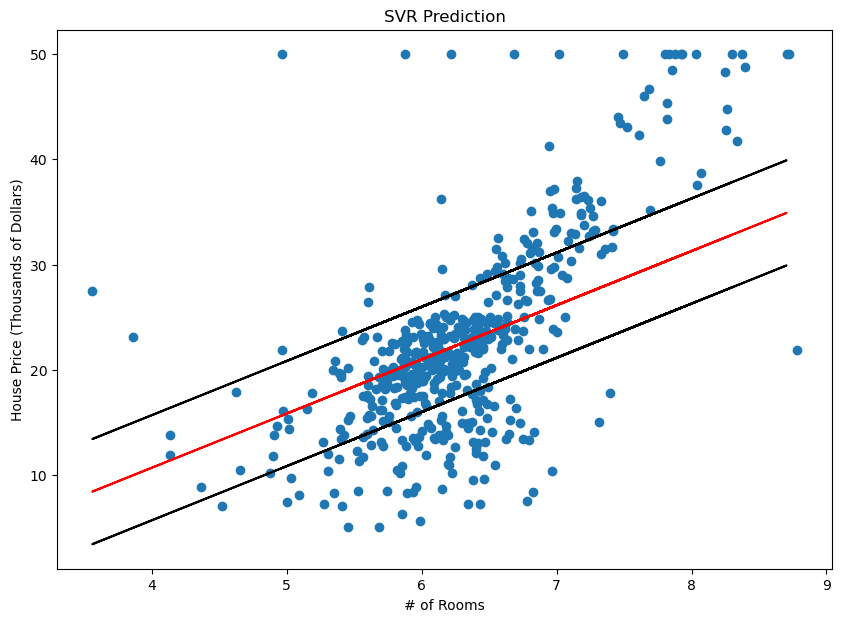

In [35]:
svr_results(y_test, X_test, svr_high_C)

**More points are within our margin $\epsilon$, when increasing C to 1.0  The above model seems to fit the data much better.**

### Vary C 
**One step further is to grid search over C to obtain an even better solution. Let’s define a scoring metric, % within $\epsilon$. This metric measures how many of the total points within the test set fall within our margin of error. Also monitor how the Mean Absolute Error (MAE) varies with C.**

In [36]:
from sklearn.metrics import mean_absolute_error

In [37]:
test_mae_list = []
perc_within_eps_list = []

eps = 5
c_space = np.linspace(0.01, 10)

for c in c_space:
    varied_svr = LinearSVR(epsilon=eps, C=c, fit_intercept=True, max_iter=10000)
    
    varied_svr.fit(X_train, y_train)
    
    test_mae = mean_absolute_error(y_test, varied_svr.predict(X_test))
    test_mae_list.append(test_mae)
    
    perc_within_eps = 100*np.sum(abs(y_test-varied_svr.predict(X_test)) <= eps) / len(y_test)
    perc_within_eps_list.append(perc_within_eps)

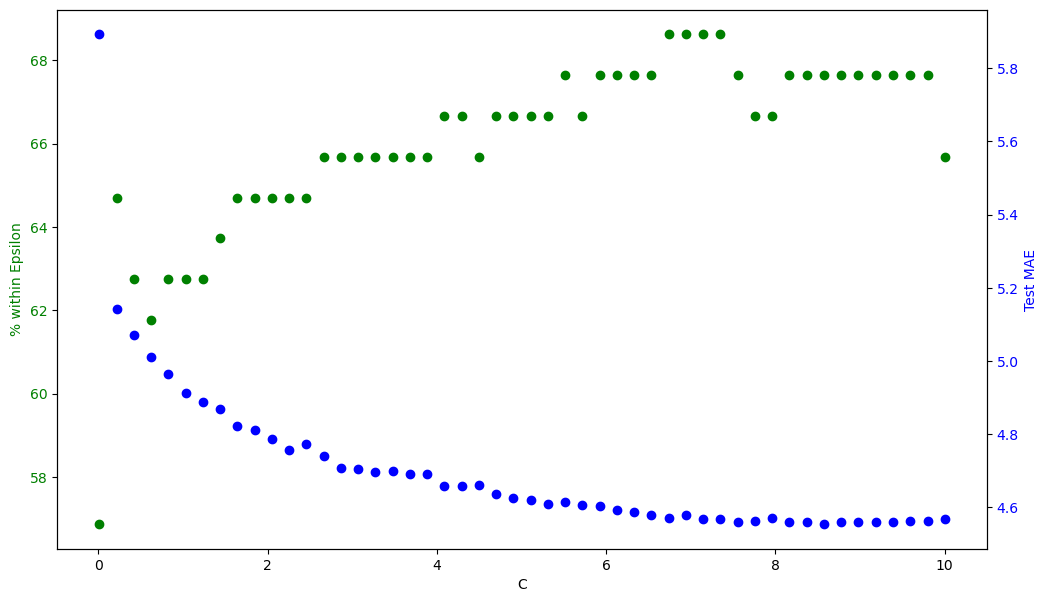

In [38]:
fig, ax1 = plt.subplots(figsize=(12,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(c_space, perc_within_eps_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(c_space, test_mae_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

**The grid search results, with values of C on the x-axis and % within Epsilon and MAE on the left and right y-axes, respectively.**

In [39]:
m = max(perc_within_eps_list)
inds = [i for i, j in enumerate(perc_within_eps_list) if j == m]
C = c_space[inds[0]]

print("best C =", C)

best C = 6.737959183673469


## Best C from GridSearch

**MAE generally decreases as C increases. However, a maximum occur in the % within Epsilon metric. Since the original objective of this model was to maximize the prediction within our margin of error (&#36;5,000), the goal is to find the value of C that maximizes % within Epsilon. Thus, C=7.14.**

C: 6.737959183673469
Epsilon: 5
Intercept: -29.128
Coefficient: 8.194
MAE = $4,567.83
Percentage within Epsilon = 86.27%


/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


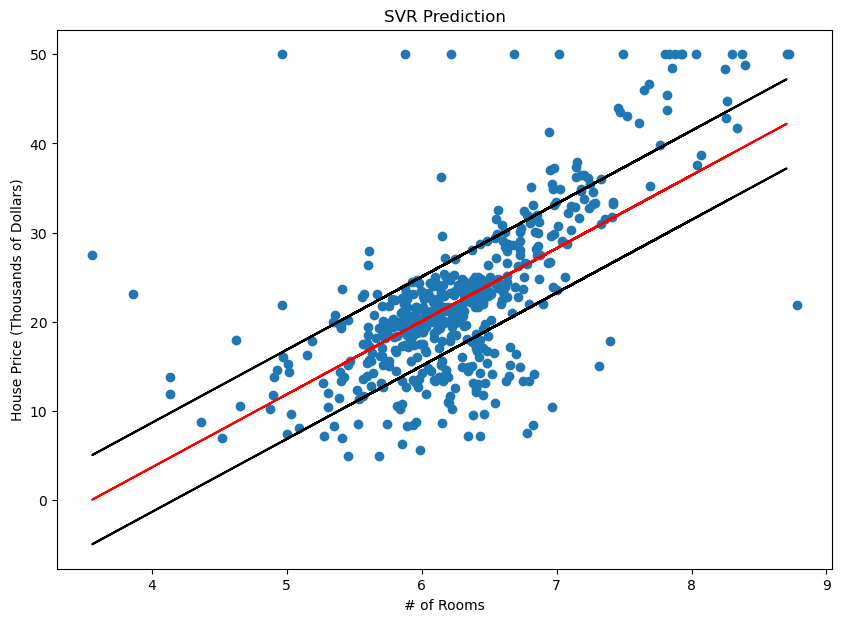

In [40]:
eps = 5
svr_best_C = LinearSVR(epsilon=eps, C=C, fit_intercept=True)
svr_best_C.fit(X_train, y_train)
svr_results(y_test, X_test, svr_best_C)

**The plot above shows that this model has again improved upon previous ones, as expected.**

## Conclusion
**SVR is a powerful algorithm that allows to choose how tolerant we are of errors, both through an acceptable error margin(ϵ) and through tuning our tolerance of falling outside that acceptable error rate.**

### Grid Search over C and Epsilon

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [42]:
grid = {
    'C': np.linspace(0.01, 10),
    'epsilon': np.linspace(0.01, 10)
}
    
svr_gridsearch =  LinearSVR(fit_intercept=True, max_iter=10000)

#### Scoring Criteria = MAE

In [43]:
grid_svr = GridSearchCV(svr_gridsearch, grid, scoring='neg_mean_absolute_error', cv=5)

In [44]:
grid_svr.fit(X_train, y_train)

/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVR(max_iter=10000),
             param_grid={'C': array([ 0.01      ,  0.21387755,  0.4177551 ,  0.62163265,  0.8255102 ,
        1.02938776,  1.23326531,  1.43714286,  1.64102041,  1.84489796,
        2.04877551,  2.25265306,  2.45653061,  2.66040816,  2.86428571,
        3.06816327,  3.27204082,  3.47591837,  3.67979592,  3.88367347,
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.1069...
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ])},
             scoring='neg_mean_absolute_error')

In [32]:
best_grid_svr_mae = grid_svr.best_estimator_
best_grid_svr_mae.fit(X_train, y_train)

LinearSVR(C=9.796122448979592, epsilon=0.41775510204081634, max_iter=10000)

C: 9.796122448979592
Epsilon: 0.41775510204081634
Intercept: -34.251
Coefficient: 9.065
MAE = $4,520.51
Percentage within Epsilon = 86.27%


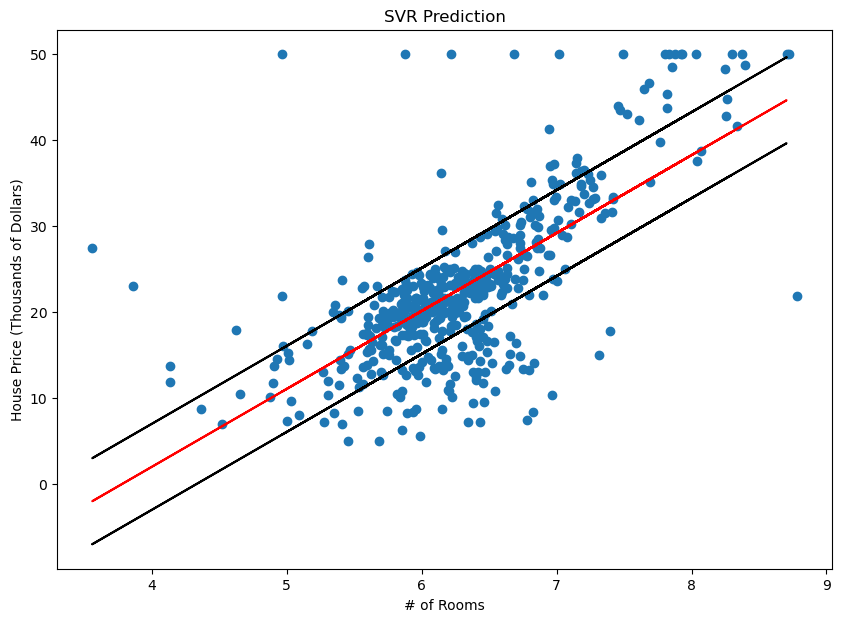

In [33]:
svr_results(y_test, X_test, best_grid_svr_mae)

#### Scoring Critera = % within Epsilon 

In [34]:
grid = {
    'C': np.linspace(0.01, 10),
    'epsilon': np.linspace(0.01, 10)
}
    
svr_gridsearch =  LinearSVR(fit_intercept=True, max_iter=10000)

In [35]:
from sklearn.metrics import make_scorer

In [36]:
def frac_within_eps(y_true, y_pred):
    return np.sum(abs(y_true-y_pred) <= eps) / len(y_true)

my_scorer = make_scorer(frac_within_eps, greater_is_better=True)

In [37]:
grid_svr_eps = GridSearchCV(svr_gridsearch, grid, scoring=my_scorer, cv=5)

In [38]:
grid_svr_eps.fit(X_train, y_train)

/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVR(max_iter=10000),
             param_grid={'C': array([ 0.01      ,  0.21387755,  0.4177551 ,  0.62163265,  0.8255102 ,
        1.02938776,  1.23326531,  1.43714286,  1.64102041,  1.84489796,
        2.04877551,  2.25265306,  2.45653061,  2.66040816,  2.86428571,
        3.06816327,  3.27204082,  3.47591837,  3.67979592,  3.88367347,
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.1069...
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ])},
             scoring=make_scorer(frac_within_eps))

In [39]:
best_grid_svr_eps = grid_svr_eps.best_estimator_

In [40]:
best_grid_svr_eps.fit(X_train, y_train)

LinearSVR(C=10.0, epsilon=3.068163265306122, max_iter=10000)

C: 10.0
Epsilon: 3.068163265306122
Intercept: -33.528
Coefficient: 8.933
MAE = $4,523.27
Percentage within Epsilon = 86.27%


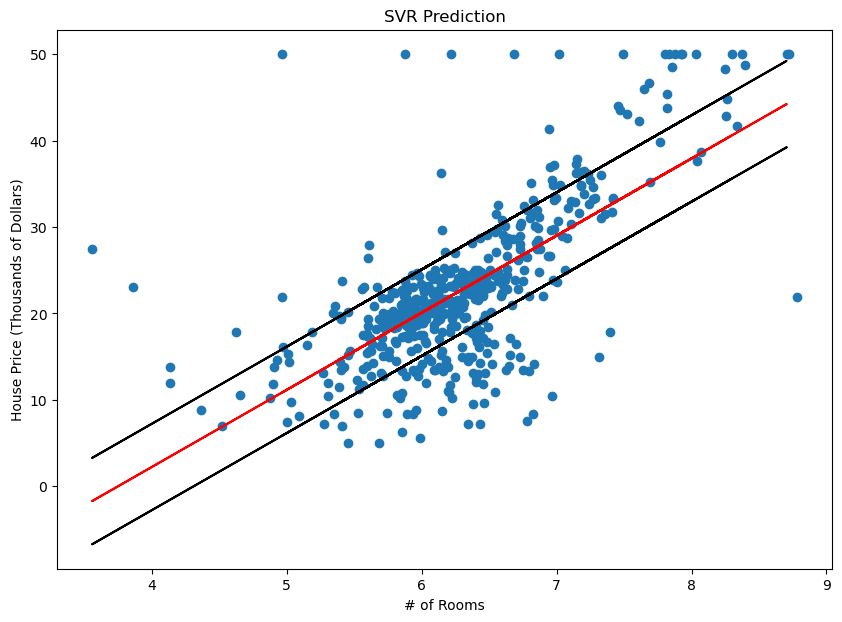

In [41]:
svr_results(y_test, X_test, best_grid_svr_eps)